# Least-Squares Fitting to Data

**References:**

- Chapter 4 *Least Squares* of {cite}`Sauer`, sections 1 and 2.
- Section 8.1 *Discrete Least Squares Approximation* of {cite}`Burden-Faires`.

We have seen that when trying to fit a curve to a large collection of data points, fitting a single polynomial to all of them can be a bad approach.
This is even more so if the data itself is inaccurate, due for example to measurement error.

Thus an important approach is to find a function of some simple form that is close to the given points but not necesarily fitting them exactly:
given $N$ points

$$(x_i, y_i),\; 1 \leq i \leq N$$

we seek a function $f(x)$ so that the errors at each point,

$$e_i = y_i - f(x_i),$$

are "small" overall, in some sense.

Two important choices for the function $f(x)$ are

(a) polynomials of low degree, and

(b) periodic sinusidal functions;

we will start with the simplest case of fitting a straight line.

## Measuring "goodness of fit": several options

The first decision to be made is how to measure the overall error in the fit, since the error is now a vector of values $e = \{e_i\}$, not a single number.
Two approaches are widely used:

* *Min-Max*: minimize the maximum of the absolute errors at each point,
$\displaystyle \|e\|_{max} \text{ or } \|e\|_\infty, = \max_{1 \leq i \leq n} |e_i|$

* *Least Squares*: Minimize the sum of the squares of the errors,
$\displaystyle \sum_1^n e_i^2$

## What doesn't work

Another seemingly natural approach is:

* Minimize the sum of the absolute errors,
$\displaystyle \|e\|_1 = \sum_1^n |e_i|$

but this often fails completely.
In the following example, all three lines minimize this measure of error, along with infinitely many others: any line that passes below half of the points and above the other half.

In [1]:
using PyPlot
using LinearAlgebra
using Random

In [2]:
include("NumericalMethods.jl")
using .NumericalMethods: solvelinearsystem, polyval

```{prf:remark}
:label: polyfit-and-multiple-dispatch

This original version of `polyfit` seen at {ref}`polyfit-polyval` in the section {doc}`polynomial-collocation+approximation` is not used here;
instead a variant is defined below that is closer to the eponymous functions in Matlab and in Python package Numpy.
Julia allows the reuse a function's name so long as the different functions are distinguished by different input parameters, a Julia feature known as *multiple dispatch*.

However, when one version comes from a module, we must use `import` rather than `using`.
(All other cases of `using .NumericalMethods` in this book could also be `import .NumericalMethods`.)
```

In [3]:
import .NumericalMethods: polyfit

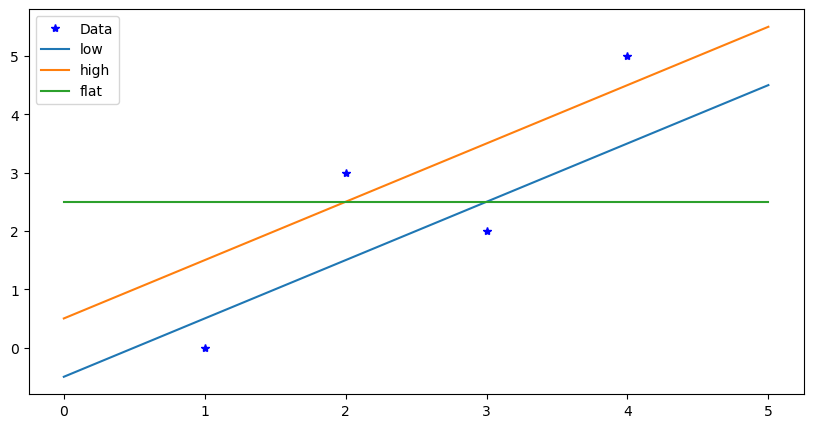

In [4]:
xdata = [1., 2., 3., 4.]
ydata = [0., 3., 2., 5.]
figure(figsize=[10,5])

plot(xdata, ydata, "b*", label="Data")
nplotpoints = 100
xplot = range(0., 5.0, nplotpoints)
ylow = xplot .- 0.5
yhigh = xplot .+ 0.5
yflat = 2.5*ones(nplotpoints)
plot(xplot, ylow, label="low")
plot(xplot, yhigh, label="high")
plot(xplot, yflat, label="flat")
legend(loc="best");

The Min-Max method is important and useful, but computationally difficult.
One hint is the presence of absolute values in the formula, which get in the way of using calculus to get equations for the minimum.

Thus the easiest and most common approach is **Least Squares**, or equivalently, minimizing the root-mean-square error, which is just the Euclidean length $\|e\|_2$ of the error vector $e$.
That "geometrical" interpretation of the goal can be useful.
So we start with that.

## Linear least squares

The simplest approach is to seek the straight line $y = f(x) = c_0 + c_1x$ that minimizes the total square sum error,

$$E(c_0, c_1) = \sum_i e_i^2 = \sum_i (c_0 + c_1x_i - y_i)^2.$$

Note well that the unknowns here are just the two values $c_0$ and $c_1$, and
$E$ is s fairly simple polynomial function of them.
The minimum error must occur at a critical point of this function, where both partial derivatives are zero:

$$\frac{\partial E}{\partial c_0} = 2 \sum_i (c_0 + c_1x_i - y_i) = 0,$$

$$\frac{\partial E}{\partial c_1} = 2 \sum_i (c_0 + c_1x_i - y_i) x_i = 0.$$

These are just simultaneous linear equations, which is the secret of why the least squares approach is so much easier than any alternative.
The equations are:

$$
\left[\begin{array}{cc} \sum_i 1 & \sum_i x_i \\ \sum_i x_i & \sum_i x_i^2 \end{array}\right]
\left[\begin{array}{c} c_0 \\ c_1 \end{array}\right]
=
\left[\begin{array}{c} \sum_i y_i \\ \sum_i x_iy_i \end{array}\right]
$$

where of course $\sum_i 1$ is just $N$.

It will help later to introduce the notation

$$m_j = \sum_i x_i^j, \quad p_j = \sum_i x_i^j y_i$$

so that the equations are

$$M c = p$$

with

$$
M = \left[\begin{array}{cc} m_0 & m_1 \\ m_1 & m_2\end{array}\right],
p = \left[\begin{array}{c} p_0 \\ p_1 \end{array}\right],
c = \left[\begin{array}{c} c_0 \\ c_1 \end{array}\right].
$$

```{prf:remark} Alternative geometrical derivation
:label: geometrical-derivation-of-least-squares

In the next section {doc}`least-squares-fitting-appendix-geometrical-approach`,
another way to derive this result is given, using geometry and linear algebra instead of calculus.
```

In [5]:
function linefit(x, y)
    m0 = length(x)
    m1 = sum(x)
    m2 = sum(x.^2)
    M = [ m0 m1 ; m1 m2 ]
    p = [ sum(y); sum(x.*y) ]
    return solvelinearsystem(M, p)
end;

The coefficients are [2.965126723118293, 2.022650331728327]

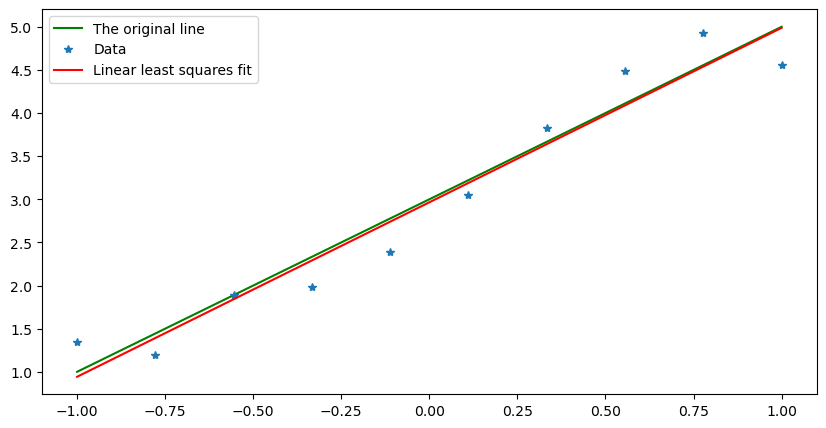

In [6]:
N = 10
xmin = -1.0
xmax = 1.0
x = range(xmin, xmax, N)
# Emulate a straight line with measurement errors:
# random(N) gives N values uniformly distributed in the range [0,1], and so with mean 0.5.
# Thus subtracting 1/2 simulates more symmetric "errors", of mean zero.
yline = 3 .+ 2x
y = yline + (rand(N) .- 0.5)

figure(figsize=[10,5])
plot(x, yline, "g", label="The original line")
plot(x, y, "*", label="Data")
c = linefit(x, y)
print("The coefficients are $c")
xplot = range(xmin, xmax, 100)
plot(xplot, polyval.(xplot, coeffs=c), "r", label="Linear least squares fit")
legend(loc="best");

## Least squares fiting to higher degree polynomials

The method above extends to finding a polynomial

$$p(x) = c_0 + c_1 x + \cdots + c_n x^n$$

that gives the best least squares fit to data

$$(x_1, y_1), \dots (x_N, y_N)$$

in that the coefficients $c_k$ given the minimum of

$$
E(c_0, \dots c_n) = \sum_i(p(x_i) - y_i)^2
= \sum_i \left( y_i - \sum_k c_k x_i^k \right)^2
$$

Note that when $N=n+1$, the solution is the interpolating polynomial, with error zero.

The necessary conditions for a minimum are that all $n+1$ partial derivatives of $E$ are zero:

$$
\frac{\partial E}{\partial c_j} = 2 \sum_i \left( y_i - \sum_k c_k x_i^k\right) x_i^j = 0,
\; 0 \leq j \leq n.
$$

This gives

$$
\sum_i \sum_k \left( c_k x_i^{j+k} \right) = \sum_k \left( \sum_i x_i^{j+k} \right) c_k = \sum_i y_i x_i^j, \; 0 \leq j \leq n,
$$

or with the notation $m_k = \sum_i x_i^k$, $p_k = \sum_i x_i^k y_i$ introduced above,

$$
\sum_k m_{j+k} c_k = p_j,\; 0 \leq j \leq n.
$$

That is, the equations are again $Mc = p$, but now with

$$
M = \left[\begin{array}{cccc}
m_0 & m_1 & \dots & m_n \\
m_1 & m_2 & \dots & m_{n+1} \\
\vdots & \vdots & \ddots & \vdots \\
m_n & m_{n+1} & \dots & m_{2n}
\end{array}\right],
\quad
p = \left[\begin{array}{c} p_0 \\ p_1 \\ \vdots \\ p_n \end{array}\right],
\quad
c = \left[\begin{array}{c} c_0 \\ c_1 \\ \vdots  \\ c_n \end{array}\right].
$$

This is done by a variation of `polyfit` with a third argument `n` specfying the degree of the polynomial sought: `polyfit(x, y, n)`.

```{prf:remark} Multiple dispatch in Julia
:label: remark-multiple-dispatch-polyfit

As mentioned above, Julia allows the following version of `polyfit` to coexist with the version at {ref}`polyfit-polyval`, which is imported above; they are distinguished by the input arguments being `(x, y)` in one case, `(x, y, n)` in the other.
```

In [7]:
function polyfit(x, y, n)
    # Version 2: least squares fitting.
    # Compute the coeffients c_i of the polynomial of degree n that give the best least squares fit to data (x[i], y[i]).

    N = length(x)
    m = zeros(2n+1)
    for k in 0:2n
        m[k+1] = sum(x.^k)  # Here and below, shift the indices up by one, since Julia counts from 1, not 0.
    end
    M = zeros(n+1,n+1)
    for i in 0:n
        for j in 0:n 
             M[i+1, j+1] = m[i+j+1]
        end
    end
    p = zeros(n+1)
    for k in 0:n
        p[k+1] = sum(x.^k .* y)
    end
    c = solvelinearsystem(M, p)
    return c
end;

This time, let us look at extrapolation too: values beyond the interval containing the data,
and try all degrees up to three:

For degree 0 the coefficients are [0.621502615138067]
For degree 1 the coefficients are [0.10638045715159698, 0.6558739019176877]
For degree 2 the coefficients are [-0.016265239454253864, 1.182904961239479, -0.335518393016084]
For degree 3 the coefficients are [-0.0010872800198948873, 1.023817333884883, -0.06859177724109337, -0.11328717424901459]


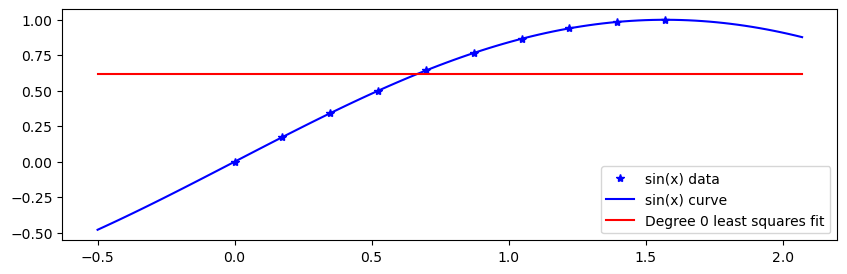

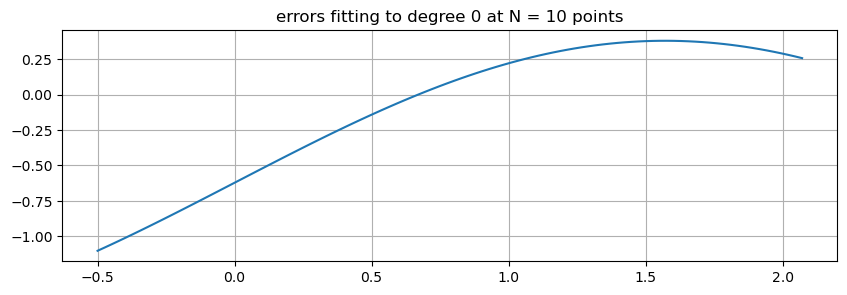

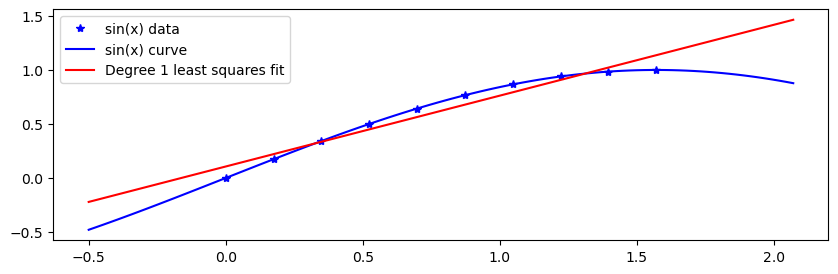

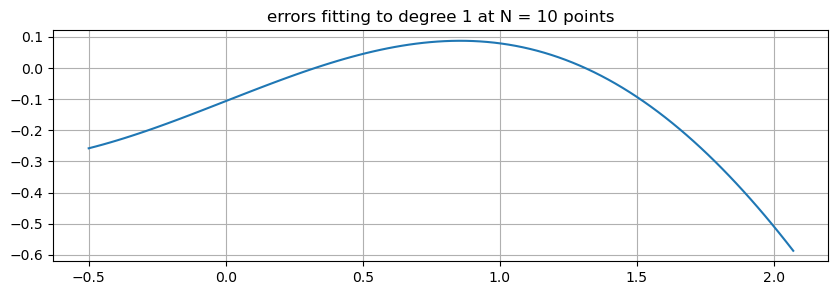

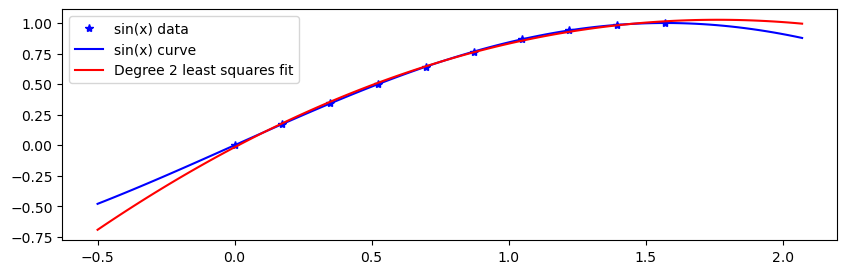

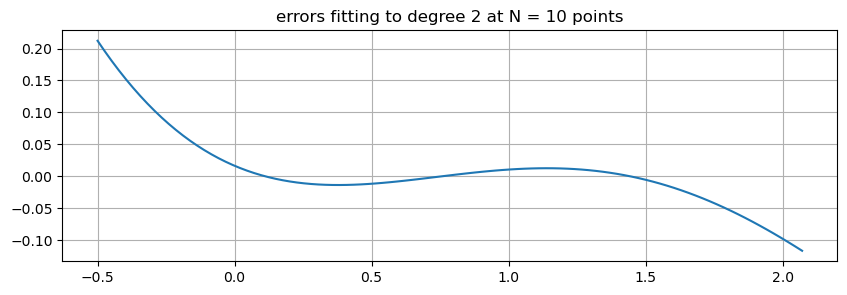

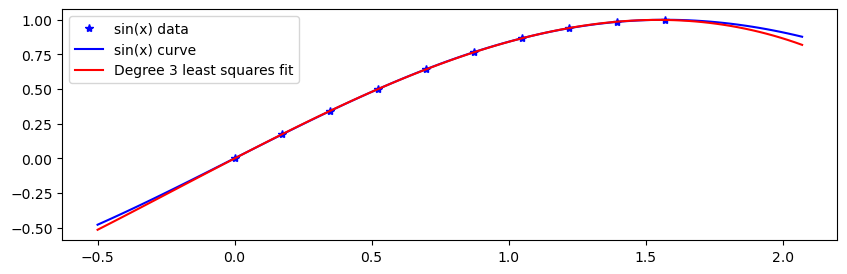

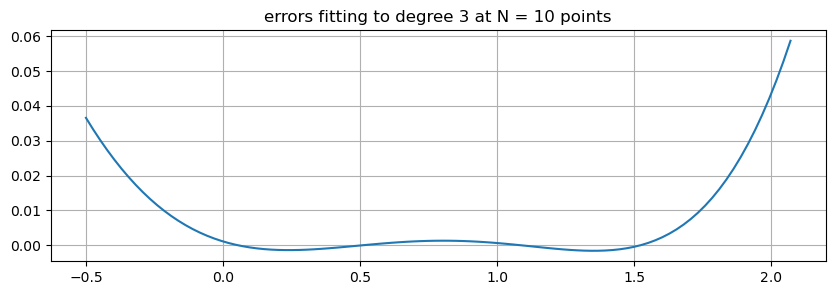

In [8]:
N = 10
n = 3
xdata = range(0.0, pi/2, N)
ydata = sin.(xdata)
for n in 0:3
    figure(figsize=[10,3])
    plot(xdata, ydata, "b*", label="sin(x) data")
    xplot = range(-0.5, pi/2 + 0.5, 100)
    plot(xplot, sin.(xplot), "b", label="sin(x) curve")
    c = polyfit(xdata, ydata, n)
    println("For degree $n the coefficients are ", c)
    plot(xplot, polyval.(xplot, coeffs=c), "r", label="Degree $n least squares fit")
    legend(loc="best")
    # Errors:
    figure(figsize=[10,3])
    plot(xplot, sin.(xplot) - polyval.(xplot, coeffs=c))
    title("errors fitting to degree $n at N = 10 points")
    grid(true)
end

What if we fit at more points?

The coefficients are [-0.002007892581016861, 1.0264756845620808, -0.06970463260725364, -0.11371819516982211]

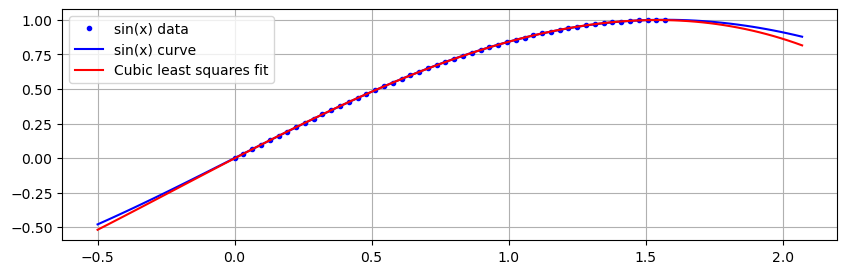

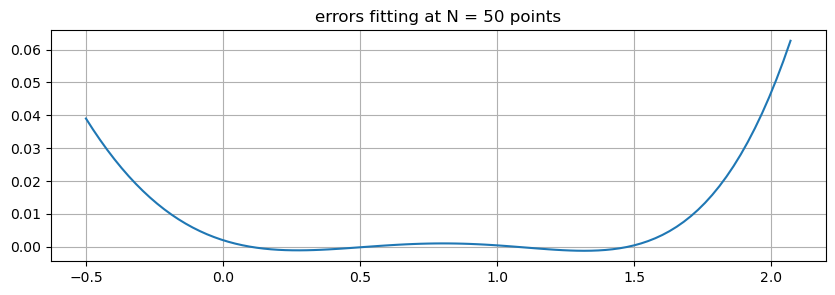

In [9]:
N = 50
xdata = range(0.0, pi/2, N)
ydata = sin.(xdata)

figure(figsize=[10,3])
plot(xdata, ydata, "b.", label="sin(x) data")
plot(xplot, sin.(xplot), "b", label="sin(x) curve")
c = polyfit(xdata, ydata, n)
print("The coefficients are ", c)
plot(xplot, polyval.(xplot, coeffs=c), "r", label="Cubic least squares fit")
legend(loc="best")
grid(true)
# Errors:
figure(figsize=[10,3])
plot(xplot, sin.(xplot) - polyval.(xplot, coeffs=c))
title("errors fitting at N = 50 points")
grid(true)

Not much changes!

This hints at another use of least squares fitting:
fitting a simpler curve (like a cubic) to a function (like $\sin(x)$), rather than to discrete data;
this is essentialy given by the limit as the number of fitting points goes to infinity.

## Nonlinear fitting: power-law relationships

When data $(x_i, y_i)$ is inherently positive, it is often natural to seek an approximate power law relationship

$$ y_i \approx c x_i^p$$

That is, one seeks the power $p$ and scale factor $c$ that minimizes error in some sense.

When the magnitudes and the data $y_i$ vary greatly, it is often appropriate to look at the relative errors

$$ e_i = \left| \frac{c x_i^p - y_i}{y_i} \right| $$

and this can be shown to be very close to looking at the absolute errors of the logarithms

$$ |\ln(c x_i^p) - \ln(y_i)| = |\ln(c) + p \ln(x_i) - \ln(y_i)| $$

Introducing the new variables $X_i = \ln(x_i)$, $Y_i = \ln(Y_i)$ and $C = \ln(c)$,
this becomes the familiar problem of finding a linear approxation of the data $Y_i$ by $C + p X_i$.

## A simulation

In [10]:
cexact = 2.0
pexact = 1.5
xmin = 0.01
xmax= 100.0
N = 100
x = (10.0).^range(log(xmin), log(xmax), N)
xplot = (10.0).^range(log(xmin), log(xmax), 100)  # For graphs later
yexact = cexact * x.^pexact
y = yexact .* (1.0 .+ (rand(N) .- 0.5)/2.0);

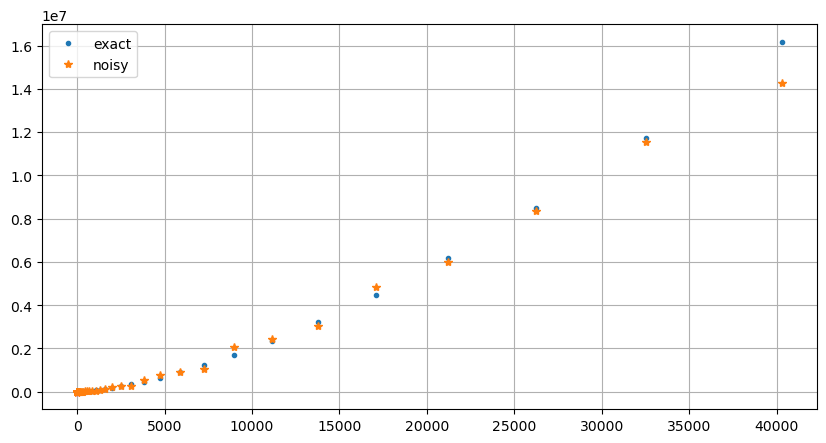

In [11]:
figure(figsize=[10,5])
plot(x, yexact, ".", label="exact")
plot(x, y, "*", label="noisy")
legend()
grid(true)

A log-log plot makes the situation far clearer:

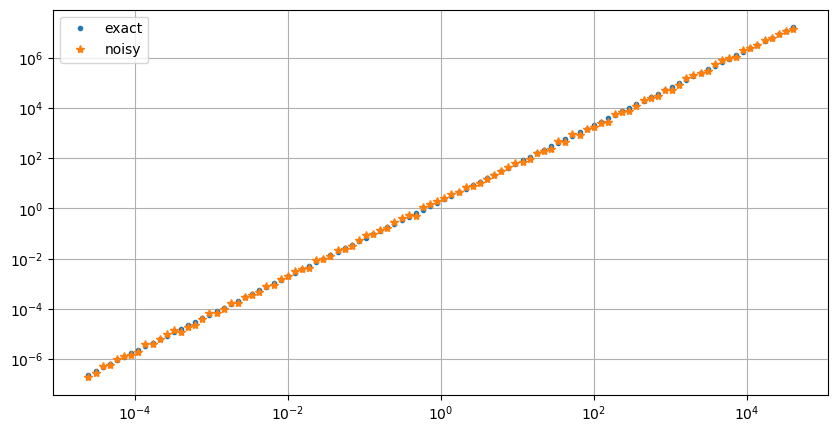

In [12]:
figure(figsize=[10,5])
loglog(x, yexact, ".", label="exact")
loglog(x, y, "*", label="noisy")
legend()
grid(true)

In [13]:
X = log.(x)
Y = log.(y)
pC = polyfit(X, Y, 1)
c = exp(pC[1])
p = pC[2]
print("p=$p, c=$c")

p=1.4995581613739783, c=1.9712066026455204

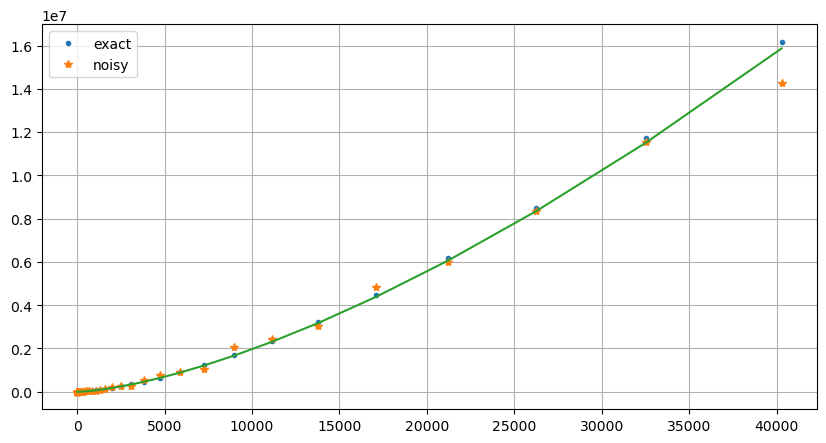

In [14]:
figure(figsize=[10,5])
plot(x, yexact, ".", label="exact")
plot(x, y, "*", label="noisy")
plot(xplot, c * xplot.^p)
legend()
grid(true)

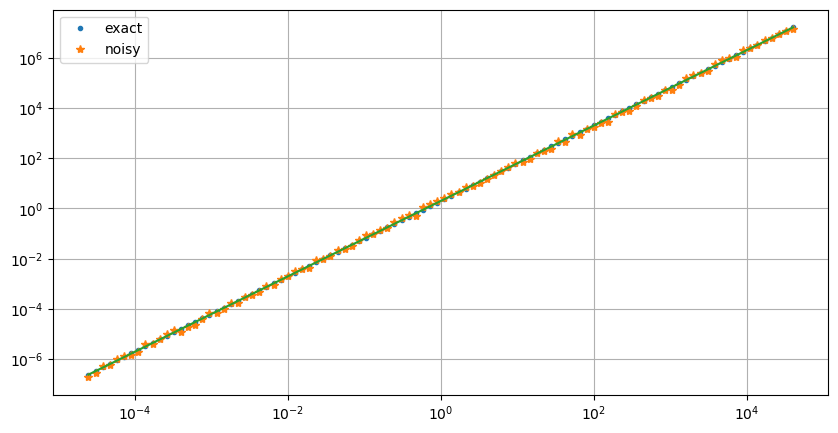

In [15]:
figure(figsize=[10,5])
loglog(x, yexact, ".", label="exact")
loglog(x, y, "*", label="noisy")
loglog(xplot, c * xplot.^p)
legend()
grid(true)